---
permalink: /neon/real-time-api/introduction
description: Beginner guide on using the real-time API client to remote control Neon devices and stream data.
isNotebook: true
---

# Introduction
For some applications it is critical to have access to eye tracking data in real time. Imagine for example an application utilizing gaze interaction to allow users to press a button using only their eyes.

In other cases it may be important to automatically start or stop a recording and save [events](/neon/basic-concepts/events/). For example, you might want to launch a screen-based experiment and have the recording start automatically when the stimulus presentation begins. Additionally, you might want to save the timestamps of when the subject interacted with the screen.

All of this is possible for developers using the [Realtime Network API](https://github.com/pupil-labs/realtime-network-api). It allows you to stream scene video, gaze, and IMU data to any device connected to the same local network. Further, you can control all devices remotely to start and stop recordings or save events.

If you are not a developer and simply need a tool to monitor and control all your devices in real-time, check out [Neon Monitor](/neon/how-tos/data-collection/monitor-your-data-collection-in-real-time.html).

We have created a Python client library for the API that makes it very easy to use. If you require access to the API from a different programming language, you will have to write your own client. Please see the documentation [here](https://pupil-labs-realtime-api.readthedocs.io/en/stable/guides/under-the-hood.html).

To install the client library execute the following command in a terminal:

```
pip install pupil-labs-realtime-api
```

### Using the Client Library
The client comes in two modes, `simple` and `async`. The simple mode is very easy to use and is the one we will focus on in this tutorial.

::: tip
You can download the code for this guide [here](https://github.com/pupil-labs/pupil-docs/tree/master/src/neon/real-time-api/introduction).
:::

The async mode is using Python's [asyncio](https://docs.python.org/3/library/asyncio.html) in order to implement non-blocking asynchronous communication. The calls made using the simple mode are blocking. If you don't know what any of this means, that's okay! The simple mode suffices for most use-cases and you usually do not need to understand the differences!

The simple client is located in [`pupil_labs.realtime_api.simple`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#simple-api). Using the [`discover_one_device`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.discover_one_device) function, we can connect to a Neon device connected to your local network. Make sure the Neon Companion app is running! If no device can be found, please check [this section](/neon/troubleshooting/#i-can-not-connect-to-devices-using-the-real-time-api) in our troubleshooting area! 

In [2]:
# The two lines below are only needed to execute this code in a Jupyter Notebook
import nest_asyncio
nest_asyncio.apply()

from pupil_labs.realtime_api.simple import discover_one_device
device = discover_one_device()

With the device connected, you can check various properties of the Companion device and the Neon:

In [2]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")
print(f"Battery level: {device.battery_level_percent}%")
print(f"Free storage: {device.memory_num_free_bytes / 1024**3:.1f} GB")
print(f"Serial number of connected glasses: {device.module_serial}")

Phone IP address: 192.168.20.69
Phone name: Neon Companion
Battery level: 58%
Free storage: 30.5 GB
Serial number of connected glasses: 676789


### Remote Control of Neon Devices
Use the [`recording_start`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.recording_start)
and [`recording_stop_and_save`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.recording_stop_and_save)
methods to remotely start and stop recordings.

In [15]:
import time

recording_id = device.recording_start()
print(f"Started recording with id {recording_id}")

time.sleep(5)

device.recording_stop_and_save()

Started recording with id 2f99d9f9-f009-4015-97dd-eb253de443b0


While a recording is running, you can save [events](/neon/basic-concepts/events)
using the [`send_event`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.send_event) method.
By default, the Neon device receiving the event will assign a timestamp to it,
using the time of arrival. Optionally, you can set a custom nanosecond timestamp for your event instead.

In [ ]:
device.recording_start()

print(device.send_event("test event 1"))

time.sleep(5)

# send event with current timestamp
print(device.send_event("test event 2", event_timestamp_unix_ns=time.time_ns()))

device.recording_stop_and_save()

Event(name=None recording_id=None timestamp_unix_ns=1642599117043000000 datetime=2022-01-19 14:31:57.043000)
Event(name=None recording_id=fd8c98ca-cd6c-4d3f-9a05-fbdb0ef42668 timestamp_unix_ns=1642599122555200500 datetime=2022-01-19 14:32:02.555201)


### Streaming Scene Video and Gaze Data
You can receive the current scene camera frame using the
[`receive_scene_video_frame`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.receive_scene_video_frame) method.
Additionally, this method returns the UTC timestamp of the frame in seconds.
The image's color space is BGR.

This scene camera image was recorded at 2023-05-25 13:59:58.347051


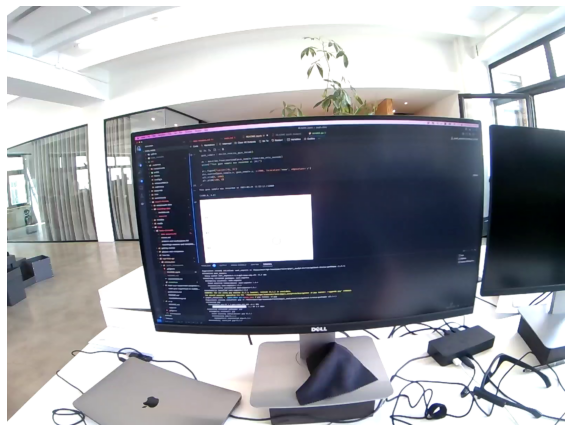

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import cv2

eye_sample = device.receive_scene_video_frame()

dt = datetime.fromtimestamp(eye_sample.timestamp_unix_seconds)
print(f"This scene camera image was recorded at {dt}")

# matplotlib expects images to be in RGB rather than BGR.
# Thus we use OpenCv to convert color spaces.
eye_image_rgb = cv2.cvtColor(eye_sample.bgr_pixels, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(eye_image_rgb)
plt.axis("off");

Analogously, you can receive gaze data using the [`receive_gaze_datum`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.receive_gaze_datum) method,
which returns a quadruple of x- and y-coordinate, a boolean whether the glasses are being worn,
and a timestamp. The timestamp is again a UTC timestamp in seconds.

This gaze sample was recorded at 2023-05-25 13:59:58.776933


(1200.0, 0.0)

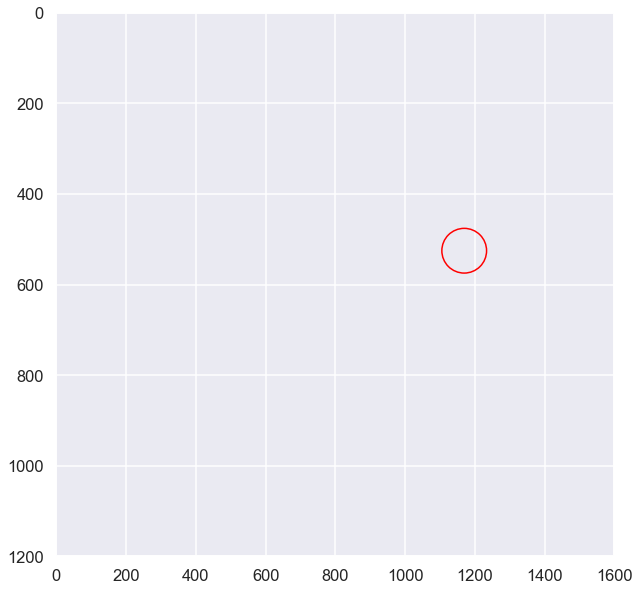

In [4]:
gaze_sample = device.receive_gaze_datum()

dt = datetime.fromtimestamp(gaze_sample.timestamp_unix_seconds)
print(f"This gaze sample was recorded at {dt}")

plt.figure(figsize=(10, 10))
plt.scatter(gaze_sample.x, gaze_sample.y, s=2000, facecolors='none', edgecolors='r')
plt.xlim(0, 1600)
plt.ylim(1200, 0)

If you tried to correlate the scene video and gaze data to e.g. make a gaze overlay visualization, you might find that there is small temporal misalignment if you simply use the most recent data.
This is because the gaze data is much smaller and is transferred more quickly. When plotting the most recent samples, the scene video would lag slightly behind.

To compensate for this you need to align the incoming data based on it's timestamps.
The client library contains a method [`receive_matched_scene_video_frame_and_gaze`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.receive_matched_scene_video_frame_and_gaze) to do all of this automatically.
It returns the most recent pair of scene video and gaze data that matches temporally.

This gaze sample was recorded at 2023-05-25 14:00:46.761394
This scene video was recorded at 2023-05-25 14:00:46.760916
Temporal difference between both is 0.5 ms


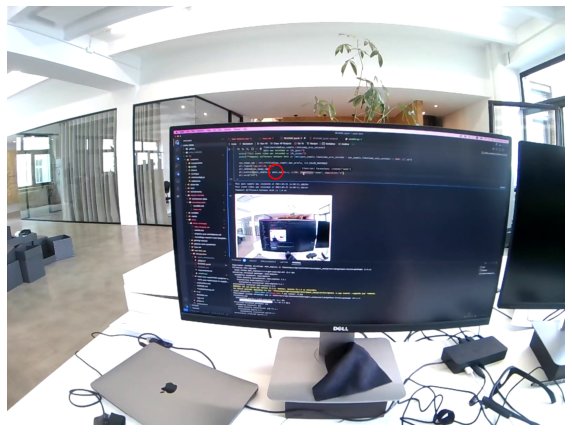

In [9]:
eye_sample, gaze_sample = device.receive_matched_scene_video_frame_and_gaze()

dt_gaze = datetime.fromtimestamp(gaze_sample.timestamp_unix_seconds)
dt_scene = datetime.fromtimestamp(eye_sample.timestamp_unix_seconds)
print(f"This gaze sample was recorded at {dt_gaze}")
print(f"This scene video was recorded at {dt_scene}")
print(f"Temporal difference between both is {abs(gaze_sample.timestamp_unix_seconds - eye_sample.timestamp_unix_seconds) * 1000:.1f} ms")

eye_image_rgb = cv2.cvtColor(eye_sample.bgr_pixels, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(eye_image_rgb)
plt.scatter(gaze_sample.x, gaze_sample.y, s=200, facecolors='none', edgecolors='r')
plt.axis("off");

## Streaming Eye Video
Data generated by the eye cameras can be received using the [`receive_eyes_frame`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.receive_eyes_frame) method. It returns a UTC timestamp in seconds and an image frame containing both eye images stitched together.

These eye camera images were recorded at 2023-05-25 14:00:07.169702


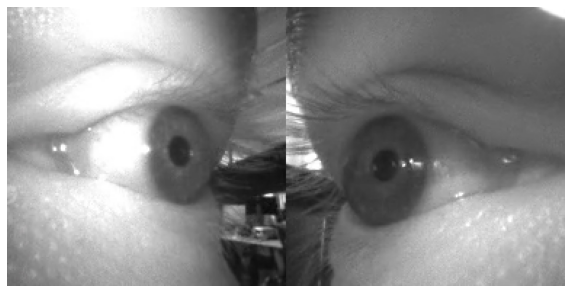

In [6]:
eyes_sample = device.receive_eyes_video_frame()

dt = datetime.fromtimestamp(eyes_sample.timestamp_unix_seconds)
print(f"These eye camera images were recorded at {dt}")

# matplotlib expects images to be in RGB rather than BGR.
# Thus we use OpenCv to convert color spaces.
eyes_image_rgb = cv2.cvtColor(eyes_sample.bgr_pixels, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(eyes_image_rgb)
plt.axis("off");

## Streaming IMU Data
Data generated by the IMU can be received using the [`receive_imu_datum`](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html#pupil_labs.realtime_api.simple.Device.receive_imu_datum) method. It returns a UTC timestamp in seconds, the head pose as a quaternion, gyro data, and accelerometer data as follows.

In [ ]:
imu_sample = device.receive_imu_datum()

dt = datetime.fromtimestamp(imu_sample.timestamp_unix_seconds)
print(f"This IMU sample was recorded at {dt}")

print(f"It contains the following data:")

print(f"Head pose:")
print(imu_sample.quaternion)

print(f"Acceleration data:")
print(imu_sample.accel_data)

print(f"Gyro data:")
print(imu_sample.gyro_data)

```
This IMU sample was recorded at 2023-05-25 11:23:05.749155
It contains the following data:
Head pose (as quaternion)
Quaternion(x=0.6989051699638367, y=0.6990674734115601, z=0.14088384807109833, w=0.05466122552752495)
Acceleration data
Data3D(x=0.1142578125, y=0.25927734375, z=-0.93701171875)
Gyro data
Data3D(x=0.1506805419921875, y=-0.1316070556640625, z=-0.0858306884765625)
```

### Conclusion

Using the simple mode of the real-time API client you can easily access scene video, gaze, and IMU data in real-time as well as remote control your Neon devices.

You can find the full API reference [here](https://pupil-labs-realtime-api.readthedocs.io/en/stable/api/simple.html).

For an example implementation on how to use the real-time API in action, please see [Track your Experiment Progress using Events](/neon/real-time-api/track-your-experiment-progress-using-events/).

To learn more about the `async` mode of the client see [here](https://pupil-labs-realtime-api.readthedocs.io/en/stable/examples/async.html).